# 08__trans_effects

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_ctrl(row):
    if "CONTROL" in row["index"]:
        return "control"
    else:
        return "TSS"

In [5]:
def trans_status(row):
    if row.fdr < 0.05:
        return "significant trans effect"
    else:
        return "no trans effect"

In [6]:
def trans_status_detail(row):
    if row.fdr < 0.05:
        if row.logFC < 0:
            return "trans effect\n(higher in human)"
        else:
            return "trans effect\n(higher in mouse)"
    else:
        return "no trans effect"

In [7]:
def trans_status_one(row):
    if row.fdr_trans_human < 0.05 or row.fdr_trans_mouse < 0.05:
        return "significant trans effect"
    else:
        return "no trans effect"

In [8]:
def trans_status_detail_one(row):
    if row.fdr_trans_human < 0.05:
        if row.fdr_trans_mouse < 0.05:
            # 2 sig trans effects: check both
            if row.logFC_trans_human < 0 and row.logFC_trans_mouse < 0:
                return "trans effect\n(higher in human)"
            elif row.logFC_trans_human > 0 and row.logFC_trans_mouse > 0:
                return "trans effect\n(higher in mouse)"
            else:
                return "trans effect\n(direction interaction)"
        else:
            # only sig in human, only check human
            if row.logFC_trans_human < 0:
                return "trans effect\n(higher in human)"
            else:
                return "trans effect\n(higher in mouse)"
    else:
        if row.fdr_trans_mouse < 0.05:
            # only sig in mouse, only check mouse
            if row.logFC_trans_mouse < 0:
                return "trans effect\n(higher in human)"
            else:
                return "trans effect\n(higher in mouse)"
        else:
            # no sig effects
            return "no trans effect"

In [9]:
def trans_logFC_one(row):
    if row.fdr_trans_human < 0.05:
        if row.fdr_trans_mouse < 0.05:
            # 2 sig trans effects: take max of both
            l2fcs = list(row[["logFC_trans_human", "logFC_trans_mouse"]])
            return signed_max(l2fcs)
        else:
            # only sig in human, return human val
            return row.logFC_trans_human
    else:
        if row.fdr_trans_mouse < 0.05:
            # only sig in mouse, return mouse val
            return row.logFC_trans_mouse
        else:
            # no sig effects: take max of both
            l2fcs = list(row[["logFC_trans_human", "logFC_trans_mouse"]])
            return signed_max(l2fcs)

In [10]:
def signed_max(nums):
    abs_nums = np.abs(nums)
    max_idx = np.argmax(abs_nums)
    return nums[max_idx]

In [11]:
def cis_trans_status(row):
    if row.cis_status_one == "no cis effect" and row.trans_status_one == "no trans effect":
        return "no cis or trans effects"
    elif row.cis_status_one != "no cis effect" and row.trans_status_one == "no trans effect":
        return "cis effect only"
    elif row.cis_status_one == "no cis effect" and row.trans_status_one != "no trans effect":
        return "trans effect only"
    else:
        if "human" in row.trans_status_detail_one and "human" in row.cis_status_detail_one:
            return "cis and trans effects\n(directional)"
        elif "mouse" in row.trans_status_detail_one and "mouse" in row.cis_status_detail_one:
            return "cis and trans effects\n(directional)"
        else:
            return "cis and trans effects\n(compensatory)"

In [12]:
def cis_trans_status_detail(row):
    if row.cis_status_one == "no cis effect" and row.trans_status_one == "no trans effect":
        return "no cis or trans effects"
    elif row.cis_status_one != "no cis effect" and row.trans_status_one == "no trans effect":
        if "human" in row.cis_status_detail_one:
            return "cis effect only\n(higher in human)"
        else:
            return "cis effect only\n(higher in mouse)"
    elif row.cis_status_one == "no cis effect" and row.trans_status_one != "no trans effect":
        if "human" in row.trans_status_detail_one:
            return "trans effect only\n(higher in human)"
        else:
            return "trans effect only\n(higher in mouse)"
    else:
        if "human" in row.trans_status_detail_one and "human" in row.cis_status_detail_one:
            return "cis and trans effects\n(directional: higher in human)"
        elif "mouse" in row.trans_status_detail_one and "mouse" in row.cis_status_detail_one:
            return "cis and trans effects\n(directional: higher in mouse)"
        else:
            return "cis and trans effects\n(compensatory)"

In [13]:
def cis_trans_status_short(row):
    if row.cis_trans_status == "no cis or trans effects":
        return "no cis or trans effects"
    else:
        return "cis and/or trans effects"

## variables

In [14]:
results_dir = "../../../data/02__mpra/03__results"
results_f = "%s/native_and_cis_effects_data.txt" % results_dir

In [15]:
data_dir = "../../../data/02__mpra/02__activs"
human_trans_f = "%s/human_trans_results.txt" % data_dir
mouse_trans_f = "%s/mouse_trans_results.txt" % data_dir

In [16]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.UPDATED.txt"

## 1. import data

In [17]:
results = pd.read_table(results_f)
results.head()

chr_tss_hg19  start_tss_hg19  end_tss_hg19 strand_tss_hg19  \
0         chr1         2985430       2985431               -   
1         chr1         8086552       8086553               +   
2         chr1        26498322      26498323               -   
3         chr1        65533428      65533429               -   
4         chr1        65533462      65533463               -   

                cage_id_hg19    biotype_hg19     name_peak_hg19  seq_orth  \
0    chr1:2985420..2985438,-         div_lnc  ENSG00000177133.6      True   
1    chr1:8086546..8086571,+         div_lnc  ENSG00000238290.1      True   
2  chr1:26498321..26498327,-  antisense_upep  ENSG00000236782.1      True   
3  chr1:65533390..65533443,-      intergenic  ENSG00000231485.1      True   
4  chr1:65533457..65533465,-      intergenic  ENSG00000231485.1      True   

   cage_orth chr_tss_mm9        ...              cis_status_detail_HUES64  \
0       True        chr4        ...                         no cis effect   
1       True        chr4        ...         cis effect\n(higher in mouse)   
2       True        chr4        ...                         no cis effect   
3       True        chr4        ...                         no cis effect   
4       True        chr4        ...         cis effect\n(higher in human)   

   fdr_cis_mESC logFC_cis_mESC abs_logFC_cis_mESC cis_status_mESC  \
0      0.777127      -0.200274           0.200274   no cis effect   
1      0.515658       0.725192           0.725192   no cis effect   
2      0.072360      -0.843083           0.843083   no cis effect   
3      0.557577       0.261450           0.261450   no cis effect   
4      0.094907      -0.689592           0.689592   no cis effect   

  cis_status_detail_mESC          cis_status_one  \
0          no cis effect           no cis effect   
1          no cis effect  significant cis effect   
2          no cis effect           no cis effect   
3          no cis effect           no cis effect   
4          no cis effect  significant cis effect   

           cis_status_detail_one logFC_cis_max abs_logFC_cis_max  
0                  no cis effect     -0.200274          0.200274  
1  cis effect\n(higher in mouse)      1.622121          1.622121  
2                  no cis effect     -0.843083          0.843083  
3                  no cis effect      0.261450          0.261450  
4  cis effect\n(higher in human)     -1.031535          1.031535  

[5 rows x 62 columns]

In [18]:
human_trans = pd.read_table(human_trans_f).reset_index()
mouse_trans = pd.read_table(mouse_trans_f).reset_index()
mouse_trans.head()

index  statistic      pval       fdr  \
0                h.2__div_lnc__m.1__div_lnc   1.656197  0.198118  0.585918   
1              h.3__div_lnc__m.2__antisense   2.304526  0.128998  0.492102   
2  h.4__antisense_upep__m.3__protein_coding   0.130904  0.717497  0.902393   
3     h.5__intergenic__m.4__intergenic_upep   4.083990  0.043291  0.311051   
4     h.6__intergenic__m.4__intergenic_upep   3.345529  0.067388  0.375934   

   df.test  df.dna  df.rna.full  df.rna.red     logFC  
0        1      14            5           4 -0.384559  
1        1      13            5           4  0.500227  
2        1      14            5           4 -0.088485  
3        1      14            5           4  0.460589  
4        1      14            5           4  0.447387

In [19]:
tss_map = pd.read_table(tss_map_f, index_col=0)
tss_map.head()

chr_tss_hg19  start_tss_hg19  end_tss_hg19 strand_tss_hg19  \
0         chr1         2984981       2984982               -   
1         chr1         2985002       2985003               -   
2         chr1         2985430       2985431               -   
3         chr1         8086552       8086553               +   
4         chr1        26498322      26498323               -   

                cage_id_hg19    biotype_hg19     name_peak_hg19  seq_orth  \
0    chr1:2984976..2984989,-         div_lnc  ENSG00000177133.6      True   
1    chr1:2984997..2985037,-         div_lnc  ENSG00000177133.6      True   
2    chr1:2985420..2985438,-         div_lnc  ENSG00000177133.6      True   
3    chr1:8086546..8086571,+         div_lnc  ENSG00000238290.1      True   
4  chr1:26498321..26498327,-  antisense_upep  ENSG00000236782.1      True   

   cage_orth chr_tss_mm9  ...    avg_exp_hg19  avg_exp_mm9  \
0       True        chr4  ...             0.1         0.43   
1       True        chr4  ...            0.29         0.43   
2       True        chr4  ...            2.54         0.85   
3       True        chr4  ...             0.3         0.14   
4       True        chr4  ...            0.19         0.25   

          stem_exp_hg19 stem_exp_mm9    har orig_species lift_species  \
0  0.027777800000000002       0.0175  False        human        mouse   
1             0.0311111       0.0175  False        human        mouse   
2   0.07111110000000001          0.0  False        human        mouse   
3   0.10444400000000001          0.0  False        human        mouse   
4                  0.03          0.0  False        human        mouse   

                               oligo_type hg19_id mm9_id  
0       human__divergent:mouse__divergent     h.0    m.0  
1       human__divergent:mouse__divergent     h.1    m.0  
2       human__divergent:mouse__divergent     h.2    m.1  
3       human__divergent:mouse__antisense     h.3    m.2  
4  human__antisense:mouse__protein_coding     h.4    m.3  

[5 rows x 26 columns]

## 2. plot trans controls vs. TSSs

In [20]:
human_trans["ctrl_status"] = human_trans.apply(is_ctrl, axis=1)
mouse_trans["ctrl_status"] = mouse_trans.apply(is_ctrl, axis=1)
mouse_trans.sample(5)

index  statistic      pval  \
978                h.1107__div_pc__m.989__div_pc   2.292235  0.130023   
1147          h.1403__enhancer__m.1085__enhancer   0.814671  0.366743   
2168  h.2506__enhancer__m.2318__no cage activity   0.085301  0.770239   
1575   h.1747__div_lnc__m.1559__no cage activity   0.865335  0.352250   
239               h.290__div_lnc__m.186__div_lnc   0.897381  0.343485   

           fdr  df.test  df.dna  df.rna.full  df.rna.red     logFC ctrl_status  
978   0.494166        1      14            5           4 -0.310208         TSS  
1147  0.728064        1      14            5           4  0.376058         TSS  
2168  0.922798        1      13            5           4  0.155533         TSS  
1575  0.719263        1      14            5           4  0.264812         TSS  
239   0.710732        1      12            5           4  0.464345         TSS

In [21]:
mouse_trans.ctrl_status.value_counts()

TSS        3279
control     400
Name: ctrl_status, dtype: int64

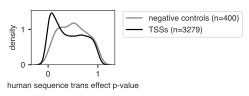

In [22]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(human_trans[human_trans["ctrl_status"] == "control"]["pval"], hist=False, color="gray",
             label="negative controls (n=%s)" % len(human_trans[human_trans["ctrl_status"] == "control"]))
sns.distplot(human_trans[human_trans["ctrl_status"] != "control"]["pval"], hist=False, color="black",
             label="TSSs (n=%s)" % len(human_trans[human_trans["ctrl_status"] != "control"]))

plt.ylabel("density")
plt.xlabel("human sequence trans effect p-value")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("human_trans_ctrl_pval_dist.pdf", dpi="figure", bbox_inches="tight")

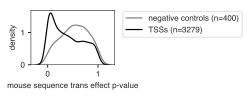

In [23]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(mouse_trans[mouse_trans["ctrl_status"] == "control"]["pval"], hist=False, color="gray",
             label="negative controls (n=%s)" % len(mouse_trans[mouse_trans["ctrl_status"] == "control"]))
sns.distplot(mouse_trans[mouse_trans["ctrl_status"] != "control"]["pval"], hist=False, color="black",
             label="TSSs (n=%s)" % len(mouse_trans[mouse_trans["ctrl_status"] != "control"]))

plt.ylabel("density")
plt.xlabel("mouse sequence trans effect p-value")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("mouse_trans_ctrl_pval_dist.pdf", dpi="figure", bbox_inches="tight")

In [24]:
human_trans["abs_logFC"] = np.abs(human_trans["logFC"])
mouse_trans["abs_logFC"] = np.abs(mouse_trans["logFC"])

In [25]:
order = ["control", "TSS"]
pal = {"control": "gray", "TSS": "black"}

4.12705106022e-32


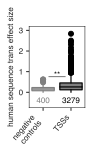

In [26]:
fig = plt.figure(figsize=(1, 1.5))
ax = sns.boxplot(data=human_trans, x="ctrl_status", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                 order=order, palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["negative\ncontrols", "TSSs"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("human sequence trans effect size")

for i, label in enumerate(order):
    n = len(human_trans[human_trans["ctrl_status"] == label])
    color = pal[label]
    ax.annotate(str(n), xy=(i, -0.6), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.75, 3.2))

# calc p-vals b/w dists
dist1 = np.asarray(human_trans[human_trans["ctrl_status"] == "control"]["abs_logFC"])
dist2 = np.asarray(human_trans[human_trans["ctrl_status"] != "control"]["abs_logFC"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 0.75, 0, 0.65, pval, fontsize)
fig.savefig("human_trans_ctrl_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

1.89994001233e-46


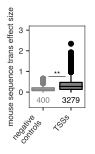

In [27]:
fig = plt.figure(figsize=(1, 1.5))
ax = sns.boxplot(data=mouse_trans, x="ctrl_status", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                 order=order, palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["negative\ncontrols", "TSSs"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("mouse sequence trans effect size")

for i, label in enumerate(order):
    n = len(mouse_trans[mouse_trans["ctrl_status"] == label])
    color = pal[label]
    ax.annotate(str(n), xy=(i, -0.6), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.75, 3.2))

# calc p-vals b/w dists
dist1 = np.asarray(mouse_trans[mouse_trans["ctrl_status"] == "control"]["abs_logFC"])
dist2 = np.asarray(mouse_trans[mouse_trans["ctrl_status"] != "control"]["abs_logFC"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 0.75, 0, 0.65, pval, fontsize)
fig.savefig("mouse_trans_ctrl_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 3. classify trans effects

In [28]:
human_trans["trans_status"] = human_trans.apply(trans_status, axis=1)
human_trans["trans_status_detail"] = human_trans.apply(trans_status_detail, axis=1)
human_trans.trans_status_detail.value_counts()

no trans effect                    3594
trans effect\n(higher in human)      59
trans effect\n(higher in mouse)      26
Name: trans_status_detail, dtype: int64

In [29]:
mouse_trans["trans_status"] = mouse_trans.apply(trans_status, axis=1)
mouse_trans["trans_status_detail"] = mouse_trans.apply(trans_status_detail, axis=1)
mouse_trans.trans_status_detail.value_counts()

no trans effect                    3590
trans effect\n(higher in mouse)      58
trans effect\n(higher in human)      31
Name: trans_status_detail, dtype: int64

## 4. merge trans effects w/ native + cis effects

In [30]:
human_trans["hg19_id"] = human_trans["index"].str.split("__", expand=True)[0]
human_trans["biotype_hg19"] = human_trans["index"].str.split("__", expand=True)[1]
human_trans["mm9_id"] = human_trans["index"].str.split("__", expand=True)[2]
human_trans["biotype_mm9"] = human_trans["index"].str.split("__", expand=True)[3]
human_trans.head()

index  statistic      pval       fdr  \
0                h.2__div_lnc__m.1__div_lnc   0.404531  0.524759  0.855511   
1              h.3__div_lnc__m.2__antisense   4.143083  0.041805  0.353646   
2  h.4__antisense_upep__m.3__protein_coding   3.086496  0.078945  0.470007   
3     h.5__intergenic__m.4__intergenic_upep   2.865521  0.090496  0.492509   
4     h.6__intergenic__m.4__intergenic_upep   1.325832  0.249548  0.668025   

   df.test  df.dna  df.rna.full  df.rna.red     logFC ctrl_status  abs_logFC  \
0        1      14            5           4 -0.217334         TSS   0.217334   
1        1      13            5           4  1.300086         TSS   1.300086   
2        1      14            5           4  0.443366         TSS   0.443366   
3        1      14            5           4  0.312604         TSS   0.312604   
4        1      14            5           4  0.200631         TSS   0.200631   

      trans_status trans_status_detail hg19_id    biotype_hg19 mm9_id  \
0  no trans effect     no trans effect     h.2         div_lnc    m.1   
1  no trans effect     no trans effect     h.3         div_lnc    m.2   
2  no trans effect     no trans effect     h.4  antisense_upep    m.3   
3  no trans effect     no trans effect     h.5      intergenic    m.4   
4  no trans effect     no trans effect     h.6      intergenic    m.4   

       biotype_mm9  
0          div_lnc  
1        antisense  
2   protein_coding  
3  intergenic_upep  
4  intergenic_upep

In [31]:
mouse_trans["hg19_id"] = mouse_trans["index"].str.split("__", expand=True)[0]
mouse_trans["biotype_hg19"] = mouse_trans["index"].str.split("__", expand=True)[1]
mouse_trans["mm9_id"] = mouse_trans["index"].str.split("__", expand=True)[2]
mouse_trans["biotype_mm9"] = mouse_trans["index"].str.split("__", expand=True)[3]
mouse_trans.head()

index  statistic      pval       fdr  \
0                h.2__div_lnc__m.1__div_lnc   1.656197  0.198118  0.585918   
1              h.3__div_lnc__m.2__antisense   2.304526  0.128998  0.492102   
2  h.4__antisense_upep__m.3__protein_coding   0.130904  0.717497  0.902393   
3     h.5__intergenic__m.4__intergenic_upep   4.083990  0.043291  0.311051   
4     h.6__intergenic__m.4__intergenic_upep   3.345529  0.067388  0.375934   

   df.test  df.dna  df.rna.full  df.rna.red     logFC ctrl_status  abs_logFC  \
0        1      14            5           4 -0.384559         TSS   0.384559   
1        1      13            5           4  0.500227         TSS   0.500227   
2        1      14            5           4 -0.088485         TSS   0.088485   
3        1      14            5           4  0.460589         TSS   0.460589   
4        1      14            5           4  0.447387         TSS   0.447387   

      trans_status trans_status_detail hg19_id    biotype_hg19 mm9_id  \
0  no trans effect     no trans effect     h.2         div_lnc    m.1   
1  no trans effect     no trans effect     h.3         div_lnc    m.2   
2  no trans effect     no trans effect     h.4  antisense_upep    m.3   
3  no trans effect     no trans effect     h.5      intergenic    m.4   
4  no trans effect     no trans effect     h.6      intergenic    m.4   

       biotype_mm9  
0          div_lnc  
1        antisense  
2   protein_coding  
3  intergenic_upep  
4  intergenic_upep

In [32]:
human_trans_sub = human_trans[["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr", "logFC", "abs_logFC",
                               "trans_status", "trans_status_detail"]]
human_trans_sub.columns = ["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr_trans_human", "logFC_trans_human", 
                           "abs_logFC_trans_human", "trans_status_human", "trans_status_detail_human"]

In [33]:
mouse_trans_sub = mouse_trans[["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr", "logFC", "abs_logFC",
                               "trans_status", "trans_status_detail"]]
mouse_trans_sub.columns = ["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr_trans_mouse", "logFC_trans_mouse", 
                           "abs_logFC_trans_mouse", "trans_status_mouse", "trans_status_detail_mouse"]

In [34]:
data = results.merge(human_trans_sub, 
                     left_on=["hg19_id", "biotype_hg19", 
                              "mm9_id", "biotype_mm9"], 
                     right_on=["hg19_id", "biotype_hg19", 
                               "mm9_id", "biotype_mm9"]).merge(mouse_trans_sub,
                                                               left_on=["hg19_id", "biotype_hg19", 
                                                                        "mm9_id", "biotype_mm9"], 
                                                               right_on=["hg19_id", "biotype_hg19", 
                                                                         "mm9_id", "biotype_mm9"])
print(len(data))
data.sample(5)

3279


chr_tss_hg19  start_tss_hg19  end_tss_hg19 strand_tss_hg19  \
1615         chr9         6645861       6645862               +   
2730         chr1       101491660     101491661               -   
798          chr1       101491339     101491340               -   
1539         chr7       150080911     150080912               -   
1806        chr17        49021977      49021978               -   

                     cage_id_hg19 biotype_hg19      name_peak_hg19  seq_orth  \
1615      chr9:6645824..6645880,+      div_lnc   ENSG00000236924.1      True   
2730  chr1:101491655..101491663,-       div_pc  ENSG00000117543.15      True   
798   chr1:101491323..101491355,-       div_pc  ENSG00000117543.15      True   
1539  chr7:150080907..150080914,-    antisense   ENSG00000239377.1      True   
1806   chr17:49021974..49021982,-      div_lnc   ENSG00000247011.2      True   

      cage_orth chr_tss_mm9            ...             fdr_trans_human  \
1615      False       chr19            ...                    0.998782   
2730       True        chr3            ...                    0.688891   
798        True        chr3            ...                    0.614484   
1539      False        chr6            ...                    0.659083   
1806      False       chr11            ...                    0.786702   

      logFC_trans_human abs_logFC_trans_human trans_status_human  \
1615           0.000660              0.000660    no trans effect   
2730          -0.254338              0.254338    no trans effect   
798           -0.418018              0.418018    no trans effect   
1539           0.316978              0.316978    no trans effect   
1806           0.159110              0.159110    no trans effect   

     trans_status_detail_human fdr_trans_mouse logFC_trans_mouse  \
1615           no trans effect        0.249946         -0.629008   
2730           no trans effect        0.721041          0.282797   
798            no trans effect        0.889658         -0.169286   
1539           no trans effect        0.968302          0.054994   
1806           no trans effect        0.953021          0.046256   

     abs_logFC_trans_mouse trans_status_mouse trans_status_detail_mouse  
1615              0.629008    no trans effect           no trans effect  
2730              0.282797    no trans effect           no trans effect  
798               0.169286    no trans effect           no trans effect  
1539              0.054994    no trans effect           no trans effect  
1806              0.046256    no trans effect           no trans effect  

[5 rows x 72 columns]

In [35]:
data["trans_status_one"] = data.apply(trans_status_one, axis=1)
data["trans_status_detail_one"] = data.apply(trans_status_detail_one, axis=1)

In [36]:
data.trans_status_one.value_counts()

no trans effect             3113
significant trans effect     166
Name: trans_status_one, dtype: int64

In [37]:
data.trans_status_detail_one.value_counts()

no trans effect                    3113
trans effect\n(higher in human)      85
trans effect\n(higher in mouse)      81
Name: trans_status_detail_one, dtype: int64

## 5. plot trans effects on scatter plot

In [38]:
# limit to those that are significant in at least 1 context
data_filt = data[(data["HUES64_padj_hg19"] < 0.05) | (data["mESC_padj_mm9"] < 0.05)]
len(data_filt)

1832

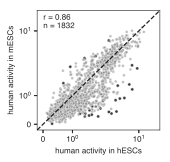

In [39]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

not_sig = data_filt[data_filt["fdr_trans_human"] >= 0.01]
sig = data_filt[data_filt["fdr_trans_human"] < 0.01]

ax.scatter(sig["HUES64_hg19"], sig["mESC_hg19"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(not_sig["HUES64_hg19"], not_sig["mESC_hg19"], s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in hESCs")
plt.ylabel("human activity in mESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["HUES64_hg19"])) & 
                   (~pd.isnull(data_filt["mESC_hg19"]))]
r, p = spearmanr(no_nan["HUES64_hg19"], no_nan["mESC_hg19"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("trans_human_scatter.pdf", dpi="figure", bbox_inches="tight")

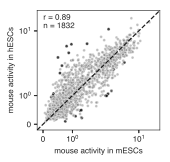

In [40]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

not_sig = data_filt[data_filt["fdr_trans_mouse"] >= 0.01]
sig = data_filt[data_filt["fdr_trans_mouse"] < 0.01]

ax.scatter(sig["mESC_mm9"], sig["HUES64_mm9"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(not_sig["mESC_mm9"], not_sig["HUES64_mm9"], s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("mouse activity in mESCs")
plt.ylabel("mouse activity in hESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["mESC_mm9"])) & 
                   (~pd.isnull(data_filt["HUES64_mm9"]))]
r, p = spearmanr(no_nan["mESC_mm9"], no_nan["HUES64_mm9"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("trans_mouse_scatter.pdf", dpi="figure", bbox_inches="tight")

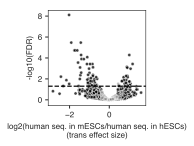

In [41]:
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

neg_ctrls = human_trans[human_trans["ctrl_status"] == "control"]
tss = human_trans[human_trans["ctrl_status"] != "control"]

ax.scatter(tss["logFC"], -np.log10(tss["fdr"]), s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(neg_ctrls["logFC"], -np.log10(neg_ctrls["fdr"]), s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("log2(human seq. in mESCs/human seq. in hESCs)\n(trans effect size)")
plt.ylabel("-log10(FDR)")
ax.axhline(y=-np.log10(0.05), color="black", linestyle="dashed")


fig.savefig("human_trans_volcano.ctrls_highlighted.pdf", dpi="figure", bbox_inches="tight")

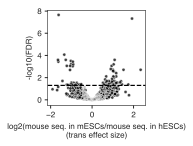

In [42]:
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

neg_ctrls = mouse_trans[mouse_trans["ctrl_status"] == "control"]
tss = mouse_trans[mouse_trans["ctrl_status"] != "control"]

ax.scatter(tss["logFC"], -np.log10(tss["fdr"]), s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(neg_ctrls["logFC"], -np.log10(neg_ctrls["fdr"]), s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("log2(mouse seq. in mESCs/mouse seq. in hESCs)\n(trans effect size)")
plt.ylabel("-log10(FDR)")
ax.axhline(y=-np.log10(0.05), color="black", linestyle="dashed")


fig.savefig("mouse_trans_volcano.ctrls_highlighted.pdf", dpi="figure", bbox_inches="tight")

In [43]:
def trans_sig_status(row):
    if row.fdr_trans_human < 0.05 and row.fdr_trans_mouse < 0.05:
        return "sig_both"
    elif row.fdr_trans_human < 0.05 and row.fdr_trans_mouse >= 0.05:
        return "sig_human"
    elif row.fdr_trans_human >= 0.05 and row.fdr_trans_mouse < 0.05:
        return "sig_mouse"
    else:
        return "not_sig_both"
    
data_filt["trans_sig_status"] = data_filt.apply(trans_sig_status, axis=1)
data_filt.trans_sig_status.value_counts()

not_sig_both    1697
sig_human         67
sig_mouse         61
sig_both           7
Name: trans_sig_status, dtype: int64

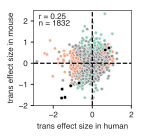

In [44]:
# plot effect size agreement b/w the two seqs
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

sig_human = data_filt[data_filt["trans_sig_status"] == "sig_human"]
sig_mouse = data_filt[data_filt["trans_sig_status"] == "sig_mouse"]
sig_both = data_filt[data_filt["trans_sig_status"] == "sig_both"]
not_sig = data_filt[data_filt["trans_sig_status"] == "not_sig_both"]

ax.scatter(not_sig["logFC_trans_human"], not_sig["logFC_trans_mouse"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_human["logFC_trans_human"], sig_human["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sig_mouse["logFC_trans_human"], sig_mouse["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")
ax.scatter(sig_both["logFC_trans_human"], sig_both["logFC_trans_mouse"], s=12, alpha=1, 
           color="black", linewidths=0.5, edgecolors="white")

plt.xlabel("trans effect size in human")
plt.ylabel("trans effect size in mouse")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-3, 2))
ax.set_ylim((-2, 2.5))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["logFC_trans_human"])) & 
                   (~pd.isnull(data_filt["logFC_trans_mouse"]))]
r, p = spearmanr(no_nan["logFC_trans_human"], no_nan["logFC_trans_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("trans_effect_bw_seqs_scatter.sig_status_color.pdf", dpi="figure", bbox_inches="tight")

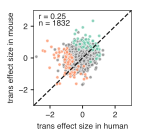

In [45]:
# plot effect size agreement b/w the two seqs
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

sig_human = data_filt[data_filt["trans_status_detail_one"].str.contains("human")]
sig_mouse = data_filt[data_filt["trans_status_detail_one"].str.contains("mouse")]
sig_int = data_filt[data_filt["trans_status_detail_one"].str.contains("interaction")]
not_sig = data_filt[data_filt["trans_status_detail_one"] == "no trans effect"]

ax.scatter(not_sig["logFC_trans_human"], not_sig["logFC_trans_mouse"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_human["logFC_trans_human"], sig_human["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sig_mouse["logFC_trans_human"], sig_mouse["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")
ax.scatter(sig_int["logFC_trans_human"], sig_int["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[3], linewidths=0.5, edgecolors="black")

plt.xlabel("trans effect size in human")
plt.ylabel("trans effect size in mouse")

ax.plot([-3, 3], [-3, 3], linestyle="dashed", color="k")
ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["logFC_trans_human"])) & 
                   (~pd.isnull(data_filt["logFC_trans_mouse"]))]
r, p = spearmanr(no_nan["logFC_trans_human"], no_nan["logFC_trans_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("trans_effect_bw_seqs_scatter.pdf", dpi="figure", bbox_inches="tight")

In [46]:
## remove trans effects w/ direction interactions for now! (there aren't any right now)
data_filt = data[~data["trans_status_detail_one"].str.contains("interaction")]

## 6. plot trans effect sizes across biotypes

In [47]:
# first determine which logFC to use since there are 2 options
data["logFC_trans_max"] = data.apply(trans_logFC_one, axis=1)
data["abs_logFC_trans_max"] = np.abs(data["logFC_trans_max"])

In [48]:
# re-filter
data_filt = data[~data["trans_status_detail_one"].str.contains("interaction")]
print(len(data_filt))
data_filt = data_filt[(data_filt["HUES64_padj_hg19"] < 0.05) | (data_filt["mESC_padj_mm9"] < 0.05)]
len(data_filt)

3279


1832

In [49]:
# # since we have 2 options here, let's plot the maximum l2fc
# data_filt["abs_logFC_trans_max"] = data_filt[["abs_logFC_trans_human", "abs_logFC_trans_mouse"]].max(axis=1)
# data_filt.sample(5)

In [50]:
clean_order = ["eRNA", "lncRNA", "mRNA"]

0.0232089740822
0.0019569799698
0.413198653868


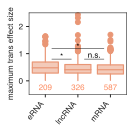

In [51]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="cleaner_biotype_hg19", y="abs_logFC_trans_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=clean_order, color=sns.color_palette("Set2")[1])
mimic_r_boxplot(ax)

ax.set_xticklabels(clean_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum trans effect size")

for i, label in enumerate(clean_order):
    n = len(data_filt[data_filt["cleaner_biotype_hg19"] == label])
    color = sns.color_palette("Set2")[1]
    ax.annotate(str(n), xy=(i, -0.4), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.5, 2.5))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "eRNA"]["abs_logFC_trans_max"])
dist2 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "lncRNA"]["abs_logFC_trans_max"])
dist3 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "mRNA"]["abs_logFC_trans_max"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u13, pval13 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
print(pval13)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

annotate_pval(ax, 0.2, 0.8, 0.8, 0, 0.74, pval12, fontsize)
annotate_pval(ax, 1.2, 1.8, 0.8, 0, 0.79, pval23, fontsize)
annotate_pval(ax, 0.2, 1.8, 1.2, 0, 1.1, pval13, fontsize)

fig.savefig("trans_clean_biotype_hg19_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [52]:
full_order = ["enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
full_labels = ["eRNA", "lincRNA", "div. lncRNA", "mRNA", "div. mRNA"]

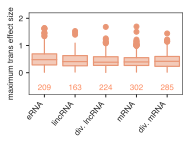

In [53]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_hg19", y="abs_logFC_trans_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_order, color=sns.color_palette("Set2")[1])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum trans effect size")

for i, label in enumerate(full_order):
    n = len(data_filt[data_filt["biotype_hg19"] == label])
    color = sns.color_palette("Set2")[1]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 2.2))

fig.savefig("trans_biotype_hg19_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

0.297677594891
0.0195621819768
0.341320788227


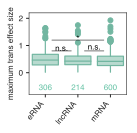

In [54]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="cleaner_biotype_mm9", y="abs_logFC_trans_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=clean_order, color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

ax.set_xticklabels(clean_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum trans effect size")

for i, label in enumerate(clean_order):
    n = len(data_filt[data_filt["cleaner_biotype_mm9"] == label])
    color = sns.color_palette("Set2")[0]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 2.2))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "eRNA"]["abs_logFC_trans_max"])
dist2 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "lncRNA"]["abs_logFC_trans_max"])
dist3 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "mRNA"]["abs_logFC_trans_max"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u13, pval13 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
print(pval13)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

annotate_pval(ax, 0.2, 0.8, 0.8, 0, 0.74, pval12, fontsize)
annotate_pval(ax, 1.2, 1.8, 0.8, 0, 0.79, pval23, fontsize)
annotate_pval(ax, 0.2, 1.8, 1.2, 0, 1.1, pval13, fontsize)

fig.savefig("trans_clean_biotype_mm9_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

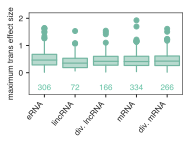

In [55]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_mm9", y="abs_logFC_trans_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_order, color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum trans effect size")

for i, label in enumerate(full_order):
    n = len(data_filt[data_filt["biotype_mm9"] == label])
    color = sns.color_palette("Set2")[0]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 2.2))

fig.savefig("trans_biotype_mm9_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [56]:
switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lincRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA",
                "eRNA", "lincRNA", "lncRNA", "mRNA"]

nan
0.615919424774
0.14084541707


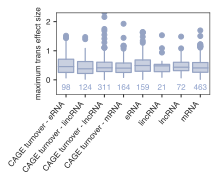

In [57]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_switch_clean", y="abs_logFC_trans_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=switch_order, color=sns.color_palette("Set2")[2])
mimic_r_boxplot(ax)

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum trans effect size")

for i, label in enumerate(switch_order):
    n = len(data_filt[data_filt["biotype_switch_clean"] == label])
    color = sns.color_palette("Set2")[2]
    ax.annotate(str(n), xy=(i, -0.4), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.5, 2.3))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "CAGE turnover"]["abs_logFC_trans_max"])
dist2 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "eRNA"]["abs_logFC_trans_max"])
dist3 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "lncRNA"]["abs_logFC_trans_max"])
dist4 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "mRNA"]["abs_logFC_trans_max"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]
dist4 = dist4[~np.isnan(dist4)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

u34, pval34 = stats.mannwhitneyu(dist3, dist4, alternative="two-sided", use_continuity=False)
print(pval34)

# annotate_pval(ax, 0.2, 0.8, 0.9, 0, 0.8, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 0.9, 0, 0.9, pval23, fontsize)
# annotate_pval(ax, 2.2, 2.8, 0.9, 0, 0.8, pval34, fontsize)

fig.savefig("trans_clean_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [58]:
full_switch_order = ["CAGE turnover - enhancer", "CAGE turnover - intergenic", "CAGE turnover - div_lnc",
                     "CAGE turnover - protein_coding", "CAGE turnover - div_pc", "enhancer", "intergenic", 
                     "div_lnc", "protein_coding", "div_pc"]
full_switch_labels = ["CAGE turnover - eRNA", "CAGE turnover - lincRNA", "CAGE turnover - div. lncRNA",
                     "CAGE turnover - mRNA", "CAGE turnover - div. mRNA", "eRNA", "lincRNA", "div. lncRNA", 
                      "mRNA", "div. mRNA"]

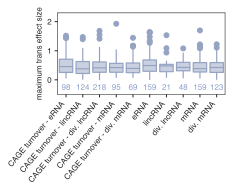

In [59]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_switch", y="abs_logFC_trans_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum trans effect size")

for i, label in enumerate(full_switch_order):
    n = len(data_filt[data_filt["biotype_switch"] == label])
    color = sns.color_palette("Set2")[2]
    ax.annotate(str(n), xy=(i, -0.4), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.5, 2.3))

# # calc p-vals b/w dists
# dist1 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "CAGE turnover"]["abs_logFC_native"])
# dist2 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "eRNA"]["abs_logFC_native"])
# dist3 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "lncRNA"]["abs_logFC_native"])
# dist4 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "mRNA"]["abs_logFC_native"])

# dist1 = dist1[~np.isnan(dist1)]
# dist2 = dist2[~np.isnan(dist2)]
# dist3 = dist3[~np.isnan(dist3)]
# dist4 = dist4[~np.isnan(dist4)]

# u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
# print(pval12)

# u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
# print(pval23)

# u34, pval34 = stats.mannwhitneyu(dist3, dist4, alternative="two-sided", use_continuity=False)
# print(pval34)

# annotate_pval(ax, 0.2, 0.8, 1.75, 0, 1.74, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 1.75, 0, 1.74, pval23, fontsize)
# annotate_pval(ax, 2.2, 2.8, 1.75, 0, 1.75, pval34, fontsize)

fig.savefig("trans_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 7. find % significant trans effects across biotypes

In [60]:
native_sig = data_filt[data_filt["native_status"] != "no native effect"]
tots = native_sig.groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
sig = native_sig[native_sig["trans_status_one"] != "no trans effect"].groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
full_sig = tots.merge(sig, on="biotype_switch", how="left").fillna(0)
full_sig["percent_sig"] = (full_sig["hg19_id_y"]/full_sig["hg19_id_x"])*100
full_sig.head()

biotype_switch  hg19_id_x  hg19_id_y  percent_sig
0       CAGE turnover - antisense         52        5.0     9.615385
1  CAGE turnover - antisense_upep         27        4.0    14.814815
2         CAGE turnover - div_lnc        101        9.0     8.910891
3          CAGE turnover - div_pc         33        1.0     3.030303
4        CAGE turnover - div_upep         35        0.0     0.000000

In [61]:
# get a hypergeometric p-value for each biotype
res = {}

tot_genes = np.sum(full_sig["hg19_id_x"])
tot_native = np.sum(full_sig["hg19_id_y"])
for biotype in full_switch_order:
    row = full_sig[full_sig["biotype_switch"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
full_sig = full_sig.merge(res, left_on="biotype_switch", right_on="index")
full_sig["padj"] = multicomp.multipletests(full_sig["pval"], method="fdr_bh")[1]
full_sig.head()

biotype_switch  hg19_id_x  hg19_id_y  percent_sig  \
0         CAGE turnover - div_lnc        101        9.0     8.910891   
1          CAGE turnover - div_pc         33        1.0     3.030303   
2        CAGE turnover - enhancer         58        7.0    12.068966   
3      CAGE turnover - intergenic         64        7.0    10.937500   
4  CAGE turnover - protein_coding         49        5.0    10.204082   

                            index      pval     padj  
0         CAGE turnover - div_lnc  0.654471  0.98132  
1          CAGE turnover - div_pc  0.966461  0.98132  
2        CAGE turnover - enhancer  0.318280  0.98132  
3      CAGE turnover - intergenic  0.418415  0.98132  
4  CAGE turnover - protein_coding  0.516262  0.98132

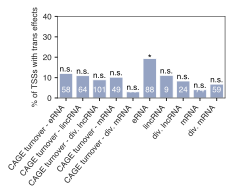

In [62]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.barplot(data=full_sig, x="biotype_switch", y="percent_sig", 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with trans effects")

for i, label in enumerate(full_switch_order):
    n = full_sig[full_sig["biotype_switch"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = full_sig[full_sig["biotype_switch"] == label]["percent_sig"].iloc[0]
    fdr = full_sig[full_sig["biotype_switch"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 40))

fig.savefig("perc_sig_trans_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

In [63]:
tots = native_sig.groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
sig = native_sig[native_sig["trans_status_one"] != "no trans effect"].groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_clean", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig.head()

biotype_switch_clean  hg19_id_x  hg19_id_y  percent_sig
0     CAGE turnover - eRNA         58          7    12.068966
1  CAGE turnover - lincRNA         64          7    10.937500
2   CAGE turnover - lncRNA        153         14     9.150327
3     CAGE turnover - mRNA         82          6     7.317073
4    CAGE turnover - other         82          9    10.975610

In [64]:
# get a fisher's exact p-value for each biotype
res = {}

tot_genes = np.sum(clean_sig["hg19_id_x"])
tot_native = np.sum(clean_sig["hg19_id_y"])
for biotype in switch_order:
    row = clean_sig[clean_sig["biotype_switch_clean"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
clean_sig = clean_sig.merge(res, left_on="biotype_switch_clean", right_on="index")
clean_sig["padj"] = multicomp.multipletests(clean_sig["pval"], method="fdr_bh")[1]
clean_sig.head()

biotype_switch_clean  hg19_id_x  hg19_id_y  percent_sig  \
0     CAGE turnover - eRNA         58          7    12.068966   
1  CAGE turnover - lincRNA         64          7    10.937500   
2   CAGE turnover - lncRNA        153         14     9.150327   
3     CAGE turnover - mRNA         82          6     7.317073   
4                     eRNA         88         17    19.318182   

                     index      pval      padj  
0     CAGE turnover - eRNA  0.318280  0.841370  
1  CAGE turnover - lincRNA  0.418415  0.841370  
2   CAGE turnover - lncRNA  0.631027  0.841370  
3     CAGE turnover - mRNA  0.823490  0.941132  
4                     eRNA  0.002390  0.019120

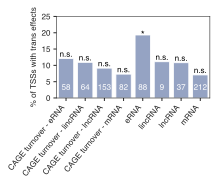

In [65]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_clean", y="percent_sig", 
                 order=switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with trans effects")

for i, label in enumerate(switch_order):
    n = clean_sig[clean_sig["biotype_switch_clean"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = clean_sig[clean_sig["biotype_switch_clean"] == label]["percent_sig"].iloc[0]
    fdr = clean_sig[clean_sig["biotype_switch_clean"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 25))

fig.savefig("perc_sig_trans_clean_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

## 8. compare trans effects to native effects

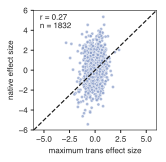

In [66]:
# plot effect size agreement b/w the two cell lines
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(data_filt["logFC_trans_max"], data_filt["logFC_native"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[2], linewidths=0.5, edgecolors="white")

plt.xlabel("maximum trans effect size")
plt.ylabel("native effect size")

ax.plot([-6, 6], [-6, 6], linestyle="dashed", color="k")
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["logFC_trans_max"])) & 
                   (~pd.isnull(data_filt["logFC_native"]))]
r, p = spearmanr(no_nan["logFC_trans_max"], no_nan["logFC_native"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("trans_v_native_scatter.pdf", dpi="figure", bbox_inches="tight")

In [67]:
no_native_sub = data_filt[data_filt["native_status"] == "no native effect"]
native_sub = data_filt[data_filt["native_status"] != "no native effect"]

In [68]:
order = ["no trans effect", "significant trans effect"]
pal = {"no trans effect": "gray", "significant trans effect": "black"}

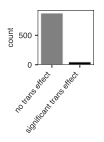

In [69]:
fig, ax = plt.subplots(figsize=(1, 1), nrows=1, ncols=1)

sns.countplot(data=no_native_sub, x="trans_status_one", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("trans_countplot.no_native.pdf", dpi="figure", bbox_inches="tight")

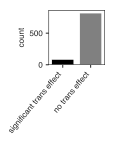

In [70]:
fig, ax = plt.subplots(figsize=(1, 1), nrows=1, ncols=1)

sns.countplot(data=native_sub, x="trans_status_one", ax=ax, order=order[::-1], palette=pal)
ax.set_xticklabels(order[::-1], va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("trans_countplot.native.pdf", dpi="figure", bbox_inches="tight")

In [71]:
len(native_sub)

906

In [72]:
len(native_sub[native_sub["trans_status_one"] == "significant trans effect"])

87

In [73]:
len(native_sub[native_sub["trans_status_one"] == "significant trans effect"])/len(native_sub)

0.09602649006622517

In [74]:
native_human_sub = data_filt[data_filt["native_status_detail"].str.contains("human")]
native_mouse_sub = data_filt[data_filt["native_status_detail"].str.contains("mouse")]

In [75]:
order = ["trans effect\n(higher in human)", "trans effect\n(higher in mouse)",
         "no trans effect"]
pal = {"no trans effect": "gray", 
       "trans effect\n(higher in human)": sns.color_palette("Set2")[1],
       "trans effect\n(higher in mouse)": sns.color_palette("Set2")[0]}

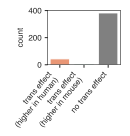

In [76]:
fig, ax = plt.subplots(figsize=(1.3, 1), nrows=1, ncols=1)

sns.countplot(data=native_human_sub, x="trans_status_detail_one", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("trans_countplot_detail.native_human.pdf", dpi="figure", bbox_inches="tight")

In [77]:
native_human_sub.trans_status_detail_one.value_counts()

no trans effect                    382
trans effect\n(higher in human)     43
trans effect\n(higher in mouse)      5
Name: trans_status_detail_one, dtype: int64

In [78]:
wrong_trans_dir_human = native_human_sub[native_human_sub["trans_status_detail_one"] == "trans effect\n(higher in mouse)"]

In [79]:
wrong_trans_dir_human.cis_status_detail_one.value_counts()

cis effect\n(higher in human)    5
Name: cis_status_detail_one, dtype: int64

In [80]:
order = ["trans effect\n(higher in mouse)", "trans effect\n(higher in human)",
         "no trans effect"]

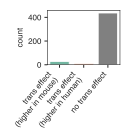

In [81]:
fig, ax = plt.subplots(figsize=(1.3, 1), nrows=1, ncols=1)

sns.countplot(data=native_mouse_sub, x="trans_status_detail_one", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("trans_countplot_detail.native_mouse.pdf", dpi="figure", bbox_inches="tight")

In [82]:
native_mouse_sub.trans_status_detail_one.value_counts()

no trans effect                    437
trans effect\n(higher in mouse)     28
trans effect\n(higher in human)     11
Name: trans_status_detail_one, dtype: int64

In [83]:
wrong_trans_dir_mouse = native_mouse_sub[native_mouse_sub["trans_status_detail_one"] == "trans effect\n(higher in human)"]

In [84]:
wrong_trans_dir_mouse.cis_status_detail_one.value_counts()

cis effect\n(higher in mouse)    11
Name: cis_status_detail_one, dtype: int64

## 9. compare trans effects to cis effects

0.148374238833


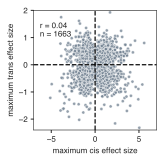

In [81]:
# plot effect size agreement b/w the two cell lines
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(data_filt["logFC_cis_max"], data_filt["logFC_trans_max"], s=10, alpha=0.75, 
           color="slategray", linewidths=0.5, edgecolors="white")

plt.xlabel("maximum cis effect size")
plt.ylabel("maximum trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-7, 7))
ax.set_ylim((-2.4, 2))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["logFC_cis_max"])) & 
                   (~pd.isnull(data_filt["logFC_trans_max"]))]
r, p = spearmanr(no_nan["logFC_cis_max"], no_nan["logFC_trans_max"])
print(p)
ax.text(0.05, 0.90, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.83, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("cis_v_trans_scatter.pdf", dpi="figure", bbox_inches="tight")

In [82]:
data_filt["cis_trans_status"] = data_filt.apply(cis_trans_status, axis=1)
data_filt.cis_trans_status.value_counts()

cis effect only                          920
no cis or trans effects                  614
cis and trans effects\n(directional)      59
cis and trans effects\n(compensatory)     44
trans effect only                         26
Name: cis_trans_status, dtype: int64

In [83]:
data_filt["cis_trans_status_detail"] = data_filt.apply(cis_trans_status_detail, axis=1)
data_filt.cis_trans_status_detail.value_counts()

no cis or trans effects                                  614
cis effect only\n(higher in human)                       496
cis effect only\n(higher in mouse)                       424
cis and trans effects\n(compensatory)                     44
cis and trans effects\n(directional: higher in human)     37
cis and trans effects\n(directional: higher in mouse)     22
trans effect only\n(higher in human)                      13
trans effect only\n(higher in mouse)                      13
Name: cis_trans_status_detail, dtype: int64

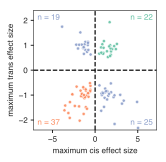

In [84]:
# plot effect size agreement b/w the two cell lines
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sub = data_filt[data_filt["cis_trans_status"].str.contains("cis and trans effects")]

sub_human = sub[sub["cis_trans_status_detail"] == "cis and trans effects\n(directional: higher in human)"]
sub_mouse = sub[sub["cis_trans_status_detail"] == "cis and trans effects\n(directional: higher in mouse)"]
sub_comp = sub[sub["cis_trans_status_detail"] == "cis and trans effects\n(compensatory)"]

ax.scatter(sub_human["logFC_cis_max"], sub_human["logFC_trans_max"], s=10, alpha=0.9, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sub_mouse["logFC_cis_max"], sub_mouse["logFC_trans_max"], s=10, alpha=0.9, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")
ax.scatter(sub_comp["logFC_cis_max"], sub_comp["logFC_trans_max"], s=10, alpha=0.9, 
           color=sns.color_palette("Set2")[2], linewidths=0.5, edgecolors="white")

plt.xlabel("maximum cis effect size")
plt.ylabel("maximum trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-7.2, 7.2))
ax.set_ylim((-2.4, 2.4))

# # annotate Ns
sub_comp_left = sub_comp[sub_comp["cis_status_detail_one"] == "cis effect\n(higher in human)"]
sub_comp_right = sub_comp[sub_comp["cis_status_detail_one"] == "cis effect\n(higher in mouse)"]
ax.text(0.03, 0.97, "n = %s" % (len(sub_comp_left)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2], transform=ax.transAxes)
ax.text(0.03, 0.03, "n = %s" % (len(sub_human)), ha="left", va="bottom", fontsize=fontsize, 
        color=sns.color_palette("Set2")[1], transform=ax.transAxes)
ax.text(0.97, 0.03, "n = %s" % (len(sub_comp_right)), ha="right", va="bottom", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2], transform=ax.transAxes)
ax.text(0.97, 0.97, "n = %s" % (len(sub_mouse)), ha="right", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[0], transform=ax.transAxes)
fig.savefig("cis_v_trans_scatter.cis_trans_only.pdf", bbox_inches="tight", dpi="figure")

(-2.4, 2.4)

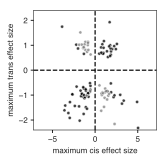

In [85]:
# plot effect size agreement b/w the two cell lines
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sub = data_filt[data_filt["cis_trans_status"].str.contains("cis and trans effects")]

sub_native = sub[sub["native_status"] != "no native effect"]
sub_no_native = sub[sub["native_status"] == "no native effect"]

ax.scatter(sub_native["logFC_cis_max"], sub_native["logFC_trans_max"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(sub_no_native["logFC_cis_max"], sub_no_native["logFC_trans_max"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("maximum cis effect size")
plt.ylabel("maximum trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-7.2, 7.2))
ax.set_ylim((-2.4, 2.4))

In [86]:
data_filt["cis_trans_short"] = data_filt.apply(cis_trans_status_short, axis=1)
data_filt.cis_trans_short.value_counts()

cis and/or trans effects    1049
no cis or trans effects      614
Name: cis_trans_short, dtype: int64

In [87]:
no_native_sub = data_filt[data_filt["native_status"] == "no native effect"]
native_sub = data_filt[data_filt["native_status"] != "no native effect"]

In [88]:
order = ["no cis or trans effects", "cis and/or trans effects"]
pal = {"no cis or trans effects": "gray", "cis and/or trans effects": "black"}

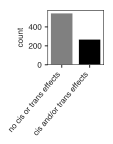

In [89]:
fig, ax = plt.subplots(figsize=(1, 1), nrows=1, ncols=1)

sns.countplot(data=no_native_sub, x="cis_trans_short", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_trans_countplot.no_native.pdf", dpi="figure", bbox_inches="tight")

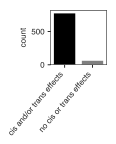

In [90]:
fig, ax = plt.subplots(figsize=(1, 1), nrows=1, ncols=1)

sns.countplot(data=native_sub, x="cis_trans_short", ax=ax, order=order[::-1], palette=pal)
ax.set_xticklabels(order[::-1], va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_trans_countplot.native.pdf", dpi="figure", bbox_inches="tight")

In [91]:
order = ["cis effect only", "trans effect only", "cis and trans effects\n(directional)", 
         "cis and trans effects\n(compensatory)", "no cis or trans effects"]
pal = {"cis effect only": "black", "trans effect only": "black", "cis and trans effects\n(directional)": "black", 
         "cis and trans effects\n(compensatory)": "black", "no cis or trans effects": "gray"}

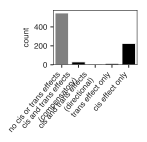

In [92]:
fig, ax = plt.subplots(figsize=(1.5, 1), nrows=1, ncols=1)

sns.countplot(data=no_native_sub, x="cis_trans_status", ax=ax, order=order[::-1], palette=pal)
ax.set_xticklabels(order[::-1], va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_trans_countplot_more.no_native.pdf", dpi="figure", bbox_inches="tight")

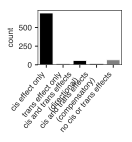

In [93]:
fig, ax = plt.subplots(figsize=(1.5, 1), nrows=1, ncols=1)

sns.countplot(data=native_sub, x="cis_trans_status", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_trans_countplot_more.native.pdf", dpi="figure", bbox_inches="tight")

In [94]:
native_sub.cis_trans_status.value_counts()

cis effect only                          695
no cis or trans effects                   67
cis and trans effects\n(directional)      57
cis and trans effects\n(compensatory)     14
trans effect only                         12
Name: cis_trans_status, dtype: int64

In [95]:
len(native_sub)

845

In [96]:
len(native_sub[native_sub["cis_trans_short"] == "cis and/or trans effects"])

778

In [97]:
len(native_sub[native_sub["cis_trans_short"] == "cis and/or trans effects"])/len(native_sub)

0.9207100591715977

In [98]:
native_human_sub = data_filt[data_filt["native_status_detail"].str.contains("human")]
native_mouse_sub = data_filt[data_filt["native_status_detail"].str.contains("mouse")]

In [99]:
data_filt.cis_trans_status_detail.value_counts()

no cis or trans effects                                  614
cis effect only\n(higher in human)                       496
cis effect only\n(higher in mouse)                       424
cis and trans effects\n(compensatory)                     44
cis and trans effects\n(directional: higher in human)     37
cis and trans effects\n(directional: higher in mouse)     22
trans effect only\n(higher in human)                      13
trans effect only\n(higher in mouse)                      13
Name: cis_trans_status_detail, dtype: int64

In [100]:
order = ["cis effect only\n(higher in human)", "cis effect only\n(higher in mouse)", 
         "trans effect only\n(higher in human)", "trans effect only\n(higher in mouse)",
         "cis and trans effects\n(directional: higher in human)", 
         "cis and trans effects\n(directional: higher in mouse)",
         "cis and trans effects\n(compensatory)",
         "no cis or trans effects"]
pal = {"no cis or trans effects": "gray", 
       "trans effect only\n(higher in human)": sns.color_palette("Set2")[1],
       "trans effect only\n(higher in mouse)": sns.color_palette("Set2")[0],
       "cis effect only\n(higher in human)": sns.color_palette("Set2")[1],
       "cis effect only\n(higher in mouse)": sns.color_palette("Set2")[0],
       "cis and trans effects\n(directional: higher in human)": sns.color_palette("Set2")[1], 
       "cis and trans effects\n(directional: higher in mouse)": sns.color_palette("Set2")[0],
       "cis and trans effects\n(compensatory)": sns.color_palette("Set2")[2]}

In [101]:
native_human_sub.cis_trans_status_detail.value_counts()

cis effect only\n(higher in human)                       349
cis and trans effects\n(directional: higher in human)     35
no cis or trans effects                                   20
trans effect only\n(higher in human)                       8
cis and trans effects\n(compensatory)                      4
Name: cis_trans_status_detail, dtype: int64

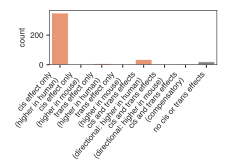

In [102]:
fig, ax = plt.subplots(figsize=(3, 1), nrows=1, ncols=1)

sns.countplot(data=native_human_sub, x="cis_trans_status_detail", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_trans_countplot_detail.native_human.pdf", dpi="figure", bbox_inches="tight")

In [103]:
tmp = native_human_sub[native_human_sub["cis_trans_status_detail"].str.contains("compensatory")]
print(len(tmp))
print(len(tmp[tmp["abs_logFC_trans_max"] < tmp["abs_logFC_cis_max"]]))
tmp.cis_status_detail_one.value_counts()

4
4


cis effect\n(higher in human)    4
Name: cis_status_detail_one, dtype: int64

In [104]:
native_mouse_sub.cis_trans_status_detail.value_counts()

cis effect only\n(higher in mouse)                       346
no cis or trans effects                                   47
cis and trans effects\n(directional: higher in mouse)     22
cis and trans effects\n(compensatory)                     10
trans effect only\n(higher in mouse)                       4
Name: cis_trans_status_detail, dtype: int64

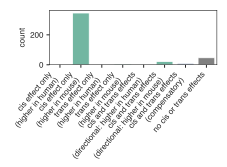

In [105]:
fig, ax = plt.subplots(figsize=(3, 1), nrows=1, ncols=1)

sns.countplot(data=native_mouse_sub, x="cis_trans_status_detail", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_trans_countplot_detail.native_mouse.pdf", dpi="figure", bbox_inches="tight")

In [106]:
tmp = native_mouse_sub[native_mouse_sub["cis_trans_status_detail"].str.contains("compensatory")]
print(len(tmp))
print(len(tmp[tmp["abs_logFC_trans_max"] < tmp["abs_logFC_cis_max"]]))
tmp.cis_status_detail_one.value_counts()

10
10


cis effect\n(higher in mouse)    10
Name: cis_status_detail_one, dtype: int64

## 10. look at cis/trans per biotype

### first directional

In [107]:
tots = data_filt.groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["cis_trans_status"].str.contains("directional")].groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
full_sig = tots.merge(sig, on="biotype_switch", how="left").fillna(0)
full_sig["percent_sig"] = (full_sig["hg19_id_y"]/full_sig["hg19_id_x"])*100
full_sig.head()

biotype_switch  hg19_id_x  hg19_id_y  percent_sig
0   CAGE turnover        748       61.0     8.155080
1       antisense          5        1.0    20.000000
2  antisense_upep          5        0.0     0.000000
3  biotype switch        416       27.0     6.490385
4         div_lnc         44        2.0     4.545455

In [110]:
# get a hypergeometric p-value for each biotype
res = {}

tot_genes = np.sum(full_sig["hg19_id_x"])
tot_native = np.sum(full_sig["hg19_id_y"])
for biotype in full_switch_order:
    row = full_sig[full_sig["biotype_switch"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
full_sig = full_sig.merge(res, left_on="biotype_switch", right_on="index")
full_sig["padj"] = multicomp.multipletests(full_sig["pval"], method="fdr_bh")[1]
full_sig.head()

biotype_switch  hg19_id_x  hg19_id_y  percent_sig          index      pval  \
0  CAGE turnover        748       61.0     8.155080  CAGE turnover  0.323351   
1        div_lnc         44        2.0     4.545455        div_lnc  0.868854   
2         div_pc        123        6.0     4.878049         div_pc  0.929523   
3       enhancer        133       21.0    15.789474       enhancer  0.000855   
4     intergenic         18        1.0     5.555556     intergenic  0.768041   

       padj  
0  0.929523  
1  0.929523  
2  0.929523  
3  0.005128  
4  0.929523

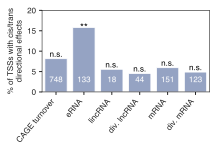

In [112]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.barplot(data=full_sig, x="biotype_switch", y="percent_sig", 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with cis/trans\ndirectional effects")

for i, label in enumerate(full_switch_order):
    n = full_sig[full_sig["biotype_switch"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = full_sig[full_sig["biotype_switch"] == label]["percent_sig"].iloc[0]
    fdr = full_sig[full_sig["biotype_switch"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 20))

fig.savefig("perc_sig_cis_trans_directional_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

In [116]:
tots = data_filt.groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["cis_trans_status"].str.contains("directional")].groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_clean", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig.head()

biotype_switch_clean  hg19_id_x  hg19_id_y  percent_sig
0        CAGE turnover        748         31     4.144385
1       biotype switch        214          4     1.869159
2                 eRNA        133         12     9.022556
3               lncRNA         87          2     2.298851
4                 mRNA        450          9     2.000000

In [117]:
# get a fisher's exact p-value for each biotype
res = {}

tot_genes = np.sum(clean_sig["hg19_id_x"])
tot_native = np.sum(clean_sig["hg19_id_y"])
for biotype in switch_order:
    row = clean_sig[clean_sig["biotype_switch_clean"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
clean_sig = clean_sig.merge(res, left_on="biotype_switch_clean", right_on="index")
clean_sig["padj"] = multicomp.multipletests(clean_sig["pval"], method="fdr_bh")[1]
clean_sig.head()

biotype_switch_clean  hg19_id_x  hg19_id_y  percent_sig          index  \
0        CAGE turnover        748         31     4.144385  CAGE turnover   
1                 eRNA        133         12     9.022556           eRNA   
2               lncRNA         87          2     2.298851         lncRNA   
3                 mRNA        450          9     2.000000           mRNA   

       pval      padj  
0  0.145584  0.291169  
1  0.001772  0.007087  
2  0.826415  0.990438  
3  0.990438  0.990438

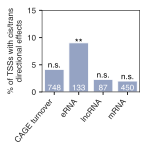

In [120]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_clean", y="percent_sig", 
                 order=switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with cis/trans\ndirectional effects")

for i, label in enumerate(switch_order):
    n = clean_sig[clean_sig["biotype_switch_clean"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 0), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = clean_sig[clean_sig["biotype_switch_clean"] == label]["percent_sig"].iloc[0]
    fdr = clean_sig[clean_sig["biotype_switch_clean"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 15))

fig.savefig("perc_sig_cis_trans_directional_clean_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

### then compensatory

In [121]:
tots = data_filt.groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["cis_trans_status"].str.contains("compensatory")].groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
full_sig = tots.merge(sig, on="biotype_switch", how="left").fillna(0)
full_sig["percent_sig"] = (full_sig["hg19_id_y"]/full_sig["hg19_id_x"])*100
full_sig.head()

biotype_switch  hg19_id_x  hg19_id_y  percent_sig
0   CAGE turnover        748       17.0     2.272727
1       antisense          5        0.0     0.000000
2  antisense_upep          5        0.0     0.000000
3  biotype switch        416       10.0     2.403846
4         div_lnc         44        2.0     4.545455

In [122]:
# get a hypergeometric p-value for each biotype
res = {}

tot_genes = np.sum(full_sig["hg19_id_x"])
tot_native = np.sum(full_sig["hg19_id_y"])
for biotype in full_switch_order:
    row = full_sig[full_sig["biotype_switch"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
full_sig = full_sig.merge(res, left_on="biotype_switch", right_on="index")
full_sig["padj"] = multicomp.multipletests(full_sig["pval"], method="fdr_bh")[1]
full_sig.head()

biotype_switch  hg19_id_x  hg19_id_y  percent_sig          index      pval  \
0  CAGE turnover        748       17.0     2.272727  CAGE turnover  0.843943   
1        div_lnc         44        2.0     4.545455        div_lnc  0.325836   
2         div_pc        123        4.0     3.252033         div_pc  0.412218   
3       enhancer        133        7.0     5.263158       enhancer  0.056201   
4     intergenic         18        0.0     0.000000     intergenic  1.000000   

       padj  
0  1.000000  
1  0.824435  
2  0.824435  
3  0.337204  
4  1.000000

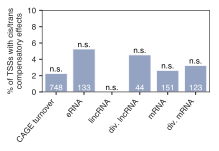

In [129]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.barplot(data=full_sig, x="biotype_switch", y="percent_sig", 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with cis/trans\ncompensatory effects")

for i, label in enumerate(full_switch_order):
    n = full_sig[full_sig["biotype_switch"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 0), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = full_sig[full_sig["biotype_switch"] == label]["percent_sig"].iloc[0]
    fdr = full_sig[full_sig["biotype_switch"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 10))

fig.savefig("perc_sig_cis_trans_compensatory_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

In [125]:
tots = data_filt.groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["cis_trans_status"].str.contains("compensatory")].groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_clean", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig.head()

biotype_switch_clean  hg19_id_x  hg19_id_y  percent_sig
0        CAGE turnover        748       17.0     2.272727
1       biotype switch        214        6.0     2.803738
2                 eRNA        133        7.0     5.263158
3               lncRNA         87        2.0     2.298851
4                 mRNA        450       12.0     2.666667

In [126]:
# get a fisher's exact p-value for each biotype
res = {}

tot_genes = np.sum(clean_sig["hg19_id_x"])
tot_native = np.sum(clean_sig["hg19_id_y"])
for biotype in switch_order:
    row = clean_sig[clean_sig["biotype_switch_clean"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
clean_sig = clean_sig.merge(res, left_on="biotype_switch_clean", right_on="index")
clean_sig["padj"] = multicomp.multipletests(clean_sig["pval"], method="fdr_bh")[1]
clean_sig.head()

biotype_switch_clean  hg19_id_x  hg19_id_y  percent_sig          index  \
0        CAGE turnover        748       17.0     2.272727  CAGE turnover   
1                 eRNA        133        7.0     5.263158           eRNA   
2               lncRNA         87        2.0     2.298851         lncRNA   
3                 mRNA        450       12.0     2.666667           mRNA   

       pval      padj  
0  0.843943  0.843943  
1  0.056201  0.224803  
2  0.681558  0.843943  
3  0.545615  0.843943

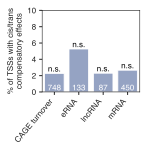

In [128]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_clean", y="percent_sig", 
                 order=switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with cis/trans\ncompensatory effects")

for i, label in enumerate(switch_order):
    n = clean_sig[clean_sig["biotype_switch_clean"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 0), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = clean_sig[clean_sig["biotype_switch_clean"] == label]["percent_sig"].iloc[0]
    fdr = clean_sig[clean_sig["biotype_switch_clean"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 10))

fig.savefig("perc_sig_cis_trans_compensatory_clean_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

In [130]:
data_filt[data_filt["cis_trans_status"].str.contains("compensatory")]

chr_tss_hg19  start_tss_hg19  end_tss_hg19 strand_tss_hg19  \
40          chr11         2721222       2721223               -   
56          chr11        82783147      82783148               +   
101         chr15        83419323      83419324               +   
260          chr6        44184664      44184665               +   
265          chr6        90539627      90539628               +   
281          chr7       104654545     104654546               -   
393          chr7        20257413      20257414               +   
464          chr4        83956353      83956354               +   
530          chr3        50365569      50365570               -   
550          chr2       200820515     200820516               +   
694          chr7       134212229     134212230               +   
732          chr7         6048975       6048976               +   
825         chr11        82904753      82904754               +   
859         chr16        87351036      87351037               -   
986          chr8       144450994     144450995               +   
1013        chr19        45195494      45195495               -   
1040         chr1       209597696     209597697               -   
1094        chr17        74128610      74128611               -   
1095        chr17        74128749      74128750               +   
1210         chr9       139550652     139550653               +   
1270         chr1        36839491      36839492               -   
1271         chr1        36839625      36839626               +   
1311        chr12        27484465      27484466               +   
1480        chr11        71159716      71159717               +   
1522        chr22        17640246      17640247               +   
1573         chr1        20513010      20513011               -   
1669         chr8       120885805     120885806               -   
1726         chr8        92082227      92082228               -   
1727         chr6       116601298     116601299               +   
1753        chr10       102133278     102133279               +   
1846         chrX       134232738     134232739               -   
1955         chr2        42252321      42252322               -   
2218         chr2       145420967     145420968               -   
2330         chr4       124317966     124317967               +   
2332         chr4       124317966     124317967               +   
2417        chr17        29601401      29601402               -   
2512         chr6        30654572      30654573               +   
2621         chr5        34656250      34656251               -   
2766         chr7        74489625      74489626               -   
2787        chr11        17229510      17229511               -   
2992        chr12        56709986      56709987               -   
3044        chr16        31084674      31084675               +   
3123        chr19         3722961       3722962               -   
3136         chr5       131803583     131803584               +   

                      cage_id_hg19      biotype_hg19  \
40        chr11:2721215..2721231,-         antisense   
56      chr11:82783097..82783155,+           div_lnc   
101     chr15:83419302..83419341,+        intergenic   
260      chr6:44184653..44184677,+   intergenic_upep   
265      chr6:90539584..90539638,+    protein_coding   
281    chr7:104654496..104654552,-           div_lnc   
393      chr7:20257403..20257421,+           div_lnc   
464      chr4:83956312..83956376,+    protein_coding   
530      chr3:50365569..50365570,-    protein_coding   
550    chr2:200820494..200820550,+            div_pc   
694    chr7:134212226..134212234,+    protein_coding   
732        chr7:6048968..6048987,+            div_pc   
825     chr11:82904746..82904832,+            div_pc   
859     chr16:87351031..87351041,-            div_pc   
986    chr8:144450985..144451002,+            div_pc   
1013       chr19:45195366-45195649          enhancer   
1040      chr1:209597695-209597830   

In [108]:
data.columns

Index(['chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19', 'strand_tss_hg19',
       'cage_id_hg19', 'biotype_hg19', 'name_peak_hg19', 'seq_orth',
       'cage_orth', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'cage_id_mm9', 'biotype_mm9', 'name_peak_mm9',
       'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19', 'stem_exp_mm9', 'har',
       'lift_species', 'oligo_type', 'hg19_id', 'mm9_id',
       'cleaner_biotype_hg19', 'cleaner_biotype_mm9', 'biotype_switch',
       'biotype_switch_clean', 'hg19_element', 'mm9_element', 'HUES64_hg19',
       'mESC_hg19', 'HUES64_pval_hg19', 'mESC_pval_hg19', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_pval_mm9',
       'mESC_pval_mm9', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'fdr_native',
       'logFC_native', 'abs_logFC_native', 'native_status',
       'native_status_detail', 'native_status_complete', 'fdr_cis_HUES64',
       'logFC_cis_HUES64', 'abs_logFC_cis_HUES64', 'cis_status_HUES64',
  

In [109]:
data.to_csv("%s/native_cis_trans_effects_data.txt" % results_dir, sep="\t", index=False)